# Setup & Process

In [1]:
import re   
import os   
import pandas as pd     
import numpy as np    
import tensorflow as tf 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split  

In [2]:
# 데이터 로드할 때 빠르게 로드
AUTOTUNE = tf.data.experimental.AUTOTUNE

ROOT_PATH =  os.path.join(os.getenv('HOME'), 'aiffel')

BATCH_SIZE = 16

IMAGE_SIZE = [150, 150]

EPOCHS = 20

nb_train_samples = 5217

nb_validation_samples = 17

In [3]:
# 배치처리 작업을 효율적으로 처리하기 위함

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*'))

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [4]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print('정상 이미지 개수: {0} \n폐렴 이미지 개수: {1}'.format(COUNT_NORMAL, COUNT_PNEUMONIA))

정상 이미지 개수: 1341 
폐렴 이미지 개수: 3875


In [5]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('train 이미지 개수: {0} \nval 이미지 개수: {1}'.format(TRAIN_IMG_COUNT, VAL_IMG_COUNT))

train 이미지 개수: 5216 
val 이미지 개수: 16


In [6]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/data/train/*"))])

In [7]:
# 라벨을 리턴하는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == "PNEUMONIA" :
        return 1
    else:
        return 0

# 이미지 형식을 재지정 해주는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

# 파일의 이미지와 라벨을 리턴하는 함수
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [8]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [9]:
# 이미지와 라벨이 잘 처리 되었는 지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  0


In [10]:
# 테스트셋도 똑같이 처리
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = str(ROOT_PATH + '/chest_xray/data/train')
validation_data_dir = str(ROOT_PATH + '/chest_xray/data/val')
test_data_dir = str(ROOT_PATH + '/chest_xray/data/test')

In [12]:
img_width, img_height = 150, 150
epochs = 20
batch_size = 16

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [16]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [17]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [18]:
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        class_weight=class_weight,)

Epoch 1/20
326/326 [==============================] - 75s 221ms/step - loss: 0.5041 - accuracy: 0.7659 - precision: 0.9073 - recall: 0.7628 - val_loss: 0.4343 - val_accuracy: 0.7500 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 2/20
326/326 [==============================] - 72s 221ms/step - loss: 0.3272 - accuracy: 0.8760 - precision: 0.9471 - recall: 0.8823 - val_loss: 0.5069 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 72s 221ms/step - loss: 0.2950 - accuracy: 0.8815 - precision: 0.9581 - recall: 0.8790 - val_loss: 0.3654 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 4/20
326/326 [==============================] - 72s 221ms/step - loss: 0.2785 - accuracy: 0.8961 - precision: 0.9613 - recall: 0.8963 - val_loss: 0.6480 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/20
326/326 [==============================] - 72s 221ms/step - loss: 0.2598 - accura

# Summary

## Basic Model

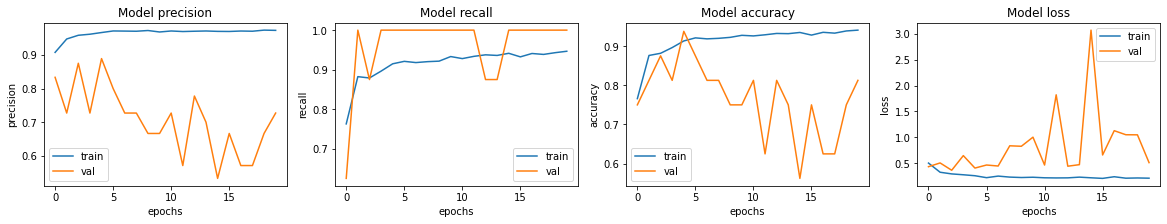

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, acc, prec, rec = model.evaluate(test_ds)


39/39 [==============================] - 5s 110ms/step - loss: 0.2078 - accuracy: 0.9231 - precision: 0.9171 - recall: 0.9641


## Applying Augmention

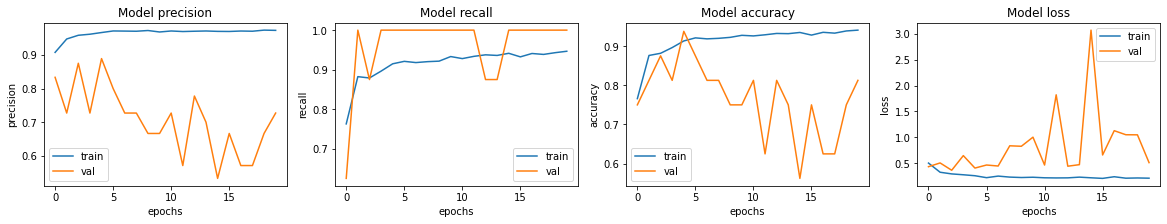

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, acc, prec, rec = model.evaluate(test_ds)


39/39 [==============================] - 4s 111ms/step - loss: 0.2078 - accuracy: 0.9231 - precision: 0.9171 - recall: 0.9641


## Applying CustomSchedule

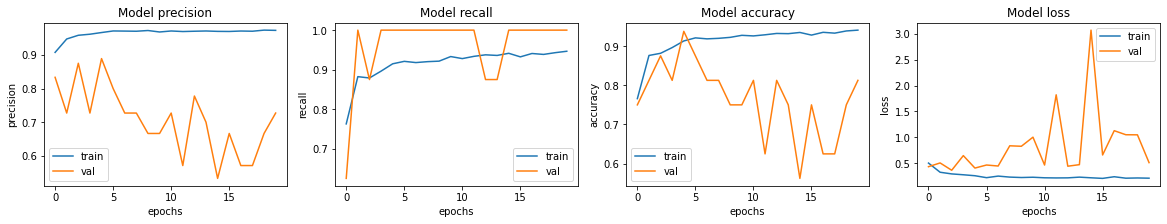

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)


39/39 [==============================] - 4s 111ms/step - loss: 0.2078 - accuracy: 0.9231 - precision: 0.9171 - recall: 0.9641


## Changing Adam Hyperparameter

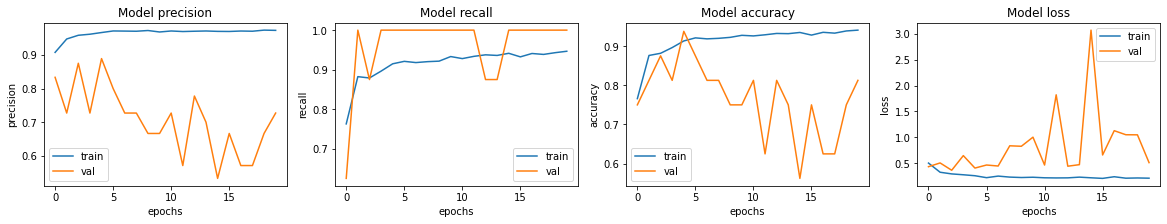

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)


39/39 [==============================] - 4s 112ms/step - loss: 0.2078 - accuracy: 0.9231 - precision: 0.9171 - recall: 0.9641


## Using Image Data Generator

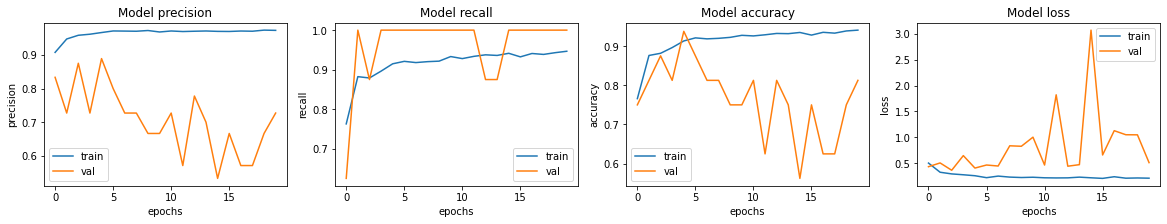

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 114ms/step - loss: 0.2078 - accuracy: 0.9231 - precision: 0.9171 - recall: 0.9641
